In [1]:
##Lets webscrap Toronto housing! 

In [1]:
from bs4 import BeautifulSoup # For HTML parsing
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import pandas as pd # For converting results to a dataframe and bar chart plots
import json # For parsing json
from requests import get
from random import randint
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

In [2]:
#get the first page of the Toronto housing prices
response = get('https://toronto.craigslist.org/search/apa')
#delete  post of an housing option without a pic using their filter

In [3]:
print(response.text[:500])

﻿<!DOCTYPE html>
<html class="no-js"><head>
    <title>toronto apts/housing for rent  - craigslist</title>

    <meta name="description" content="toronto apts/housing for rent  - craigslist">
    <meta http-equiv="X-UA-Compatible" content="IE=Edge"/>
    <link rel="canonical" href="https://toronto.craigslist.org/search/apa">
    <link rel="alternate" type="application/rss+xml" href="https://toronto.craigslist.org/search/apa?format=rss" title="RSS feed for craigslist | toronto apts/housing for re


In [4]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
type(html_soup)

bs4.BeautifulSoup

In [6]:
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 50 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [7]:
#The first post on craiglist
post_one = posts[0]
post_one

<li class="result-row" data-pid="6972413584">
<a class="result-image gallery" data-ids="1:00Y0Y_epapWGIzz23,1:00a0a_2CD5xGJWsVu,1:00t0t_14yg7lpDxsh,1:00x0x_2Od5YxyuhBt,1:00g0g_b1fKQC89dAi,1:00P0P_bSVc9m5Nkbs,1:00h0h_dOhlqOtVh5V,1:00V0V_bPV5kAfdVIP,1:00w0w_lS7L7Dt1Uj1,1:00N0N_9ROEbJTKcMH,1:00101_7bJu6QQ28he,1:00k0k_f4gch3rIFQb" href="https://toronto.craigslist.org/tor/apa/d/toronto-1brden-with-g-parking-and/6972413584.html">
<span class="result-price">$3199</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2019-09-05 21:16" title="Thu 05 Sep 09:16:35 PM">Sep  5</time>
<a class="result-title hdrlnk" data-id="6972413584" href="https://toronto.craigslist.org/tor/apa/d/toronto-1brden-with-g-parking-and/6972413584.html">1BR+Den with U/G Parking and double sized locker at 19 Brant Street</a>
<span class="result-meta">
<span class="result-price">$3199</span>
<spa

In [8]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price

'\n$3199\n'

In [9]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

#split them and grab each element of the resulting list to get date and time
post_one_datetime = post_one_datetime.split(' ')
post_one_date = post_one_datetime[0]
post_one_date

#element 2 is the time
post_one_time = post_one_datetime[1]

post_one_time

'21:16'

In [10]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']
post_one_link

'https://toronto.craigslist.org/tor/apa/d/toronto-1brden-with-g-parking-and/6972413584.html'

In [11]:
#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
post_one_title_text

'1BR+Den with U/G Parking and double sized locker at 19 Brant Street'

In [12]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = post_one.find('span', class_= 'result-hood').text
post_one_hood

' (King Street West)'

In [13]:
#getting sqft
post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3]
post_one_sqft

AttributeError: 'NoneType' object has no attribute 'text'

In [14]:
#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)

pages = np.arange(0, results_total, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
post_links = []
post_prices = []
sqfts = []
bedroom_counts = []
for page in pages:
    
    #get request
    response = get("https://toronto.craigslist.org/search/eby/apt?" 
                   + "s=" 
                   + str(page) 
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span',class_ = 'result-price') is None:
                post_price = np.nan
            else:
                post_price = post.a.text.strip().replace("\n$", "")
                post_prices.append(post_price)
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
                


    iterations += 1
    print("Finished iteration: " + str(iterations))

Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25


In [15]:
import pandas as pd

to_rooms = pd.DataFrame({'Date Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post Title': post_title_texts,
                       'URL': post_links,
                       'Price': post_prices,
                       'Sqft':sqfts,
                        'Bedrooms':bedroom_counts})

In [16]:
to_rooms.head(2000)

,Date Posted,Neighborhood,Post Title,URL,Price,Sqft,Bedrooms
0,2019-09-05 21:16,(King Street West),1BR+Den with U/G Parking and double sized lock...,https://toronto.craigslist.org/tor/apa/d/toron...,$3199,NaN,NaN
1,2019-09-05 21:14,(25 Soho St),Bright 2-Storey Corner Unit On A Quiet Neighbo...,https://toronto.craigslist.org/tor/apa/d/downt...,$3300,1100.0,2
2,2019-09-05 21:13,(Cabbagetown Toronto),*** 1BR + DEN BRIGHT LARGE RENO (DOWNTOWN/ CAB...,https://toronto.craigslist.org/tor/apa/d/toron...,$2200,625.0,2
3,2019-09-05 21:10,(Newmarket),$1250 / Newmarket two-bedroom basement apartme...,https://toronto.craigslist.org/yrk/apa/d/newma...,$1250,1300.0,2
4,2019-09-05 21:08,(Toronto),2-BR TOP FLOOR APARTMENT NEAR BLOOR & LANSDOWNE,https://toronto.craigslist.org/tor/apa/d/toron...,$2100,750.0,2
5,2019-09-05 21:03,(High Park),1 bedroom apartment in High Park,https://toronto.craigslist.org/tor/apa/d/toron...,$1950,NaN,1
6,2019-09-05 20:31,"(Ajax, ON,)",Beautiful Detached Home By Sundial. 3+1 Bedroo...,https://toronto.craigslist.org/tor/apa/d/ajax-...,$1400,NaN,3
7,2019-09-05 20:29,(Carr Street Toronto),CLASSIC AND BEAUTIFUL CONDO,https://toronto.craigslist.org/tor/apa/d/toron...,$1500,500.0,1
8,2019-09-05 20:24,(Toronto),DISTILLERY DISTRICT 1 BEDROOM RENTAL,https://toronto.craigslist.org/yrk/apa/d/downt...,$2300,620.0,1
9,2019-09-05 20:12,(Toronto),Nice j.1bedroom for September,https://toronto.craigslist.org/tor/apa/d/toron...,,400.0,1


In [20]:
to_rooms.URL

0       https://toronto.craigslist.org/tor/apa/d/toron...
1       https://toronto.craigslist.org/tor/apa/d/toron...
2       https://toronto.craigslist.org/tor/apa/d/toron...
3       https://toronto.craigslist.org/tor/apa/d/scarb...
4       https://toronto.craigslist.org/tor/apa/d/downt...
5       https://toronto.craigslist.org/tor/apa/d/scarb...
6       https://toronto.craigslist.org/tor/apa/d/toron...
7       https://toronto.craigslist.org/tor/apa/d/toron...
8       https://toronto.craigslist.org/tor/apa/d/toron...
9       https://toronto.craigslist.org/tor/apa/d/toron...
10      https://toronto.craigslist.org/tor/apa/d/toron...
11      https://toronto.craigslist.org/tor/apa/d/north...
12      https://toronto.craigslist.org/tor/apa/d/downt...
13      https://toronto.craigslist.org/tor/apa/d/oshaw...
14      https://toronto.craigslist.org/tor/apa/d/downt...
15      https://toronto.craigslist.org/tor/apa/d/toron...
16      https://toronto.craigslist.org/tor/apa/d/downt...
17      https:

In [17]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 7 columns):
Date Posted     2675 non-null object
Neighborhood    2675 non-null object
Post Title      2675 non-null object
URL             2675 non-null object
Price           2675 non-null object
Sqft            1475 non-null float64
Bedrooms        2575 non-null object
dtypes: float64(1), object(6)
memory usage: 146.4+ KB


In [18]:
to_rooms['Price']=to_rooms['Price'].str.replace('$','')
to_rooms['Neighborhood']=to_rooms['Neighborhood'].str.replace('(','')
to_rooms['Neighborhood']=to_rooms['Neighborhood'].str.replace(')','')
to_rooms['Bedrooms'] = to_rooms['Bedrooms'].apply(lambda x: float(x))
#to_rooms = to_rooms.drop_duplicates(subset='URL')
print(to_rooms.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 7 columns):
Date Posted     2675 non-null object
Neighborhood    2675 non-null object
Post Title      2675 non-null object
URL             2675 non-null object
Price           2675 non-null object
Sqft            1475 non-null float64
Bedrooms        2575 non-null float64
dtypes: float64(2), object(5)
memory usage: 146.4+ KB
None


In [19]:
to_rooms['Date Posted'] = pd.to_datetime(to_rooms['Date Posted'])
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 7 columns):
Date Posted     2675 non-null datetime64[ns]
Neighborhood    2675 non-null object
Post Title      2675 non-null object
URL             2675 non-null object
Price           2675 non-null object
Sqft            1475 non-null float64
Bedrooms        2575 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 146.4+ KB


In [20]:
to_rooms['Price'] = to_rooms['Price'].astype(str)

In [21]:
import re

to_rooms['Price'] = to_rooms['Price'].apply(lambda x: re.sub(r'[\n$]+', '', x))

#replace '' with NaN values in the df before turning the column to int so data shape is maintained

In [22]:
import numpy as np
to_rooms['Price'].replace('', np.nan, inplace=True)

In [23]:
#drop the NAs because we dont like na
to_rooms = to_rooms.dropna()

In [24]:
to_rooms.info() #we still need to change the price to an int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 1 to 2674
Data columns (total 7 columns):
Date Posted     1300 non-null datetime64[ns]
Neighborhood    1300 non-null object
Post Title      1300 non-null object
URL             1300 non-null object
Price           1300 non-null object
Sqft            1300 non-null float64
Bedrooms        1300 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 81.2+ KB


In [29]:
#now turn the price to int as well
to_rooms['Price'] = to_rooms['Price'].astype(int)

In [30]:
to_rooms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 0 to 2373
Data columns (total 7 columns):
Date Posted     1125 non-null datetime64[ns]
Neighborhood    1125 non-null object
Post Title      1125 non-null object
URL             1125 non-null object
Price           1125 non-null int32
Sqft            1125 non-null float64
Bedrooms        1125 non-null float64
dtypes: datetime64[ns](1), float64(2), int32(1), object(3)
memory usage: 65.9+ KB


D:\anacoda python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


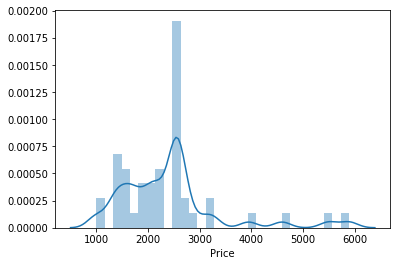

In [31]:
#start to look at the distributions
from matplotlib import figure
import matplotlib as plt
import seaborn as sns
%matplotlib inline

sns.distplot(to_rooms['Price']);

In [32]:
to_rooms.head(200)  

,Date Posted,Neighborhood,Post Title,URL,Price,Sqft,Bedrooms
0,2019-09-04 21:19:00,Yonge # Eglinton,2 bed room new unit in a condo for rent,https://toronto.craigslist.org/tor/apa/d/toron...,2700,750.0,2.0
2,2019-09-04 21:18:00,Yonge # Eglinton,2 bed room new unit in a condo for rent,https://toronto.craigslist.org/tor/apa/d/toron...,2700,750.0,2.0
4,2019-09-04 21:15:00,250 Queens Quay Quay W,Stunning View Of The Lake And The Island Airpo...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,799.0,1.0
7,2019-09-04 21:08:00,85 Wood St,Open & Bright Brand New Axis Condo In Prime Do...,https://toronto.craigslist.org/tor/apa/d/toron...,2550,599.0,1.0
8,2019-09-04 21:04:00,197 Yonge St,Stunning Beautiful 1BR+Den Condo In Luxurious ...,https://toronto.craigslist.org/tor/apa/d/toron...,2550,699.0,1.0
9,2019-09-04 20:56:00,toronto,Executive Rental in Toronto's Famous 'Beach',https://toronto.craigslist.org/tor/apa/d/toron...,1000,700.0,1.0
10,2019-09-04 20:44:00,"Parkdale, Toronto",Parkdale 1-bedroom apartment,https://toronto.craigslist.org/tor/apa/d/toron...,2250,800.0,1.0
16,2019-09-04 20:24:00,101 Peter St,4 Year New One Bedroom With Amazing South Lake...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,599.0,1.0
17,2019-09-04 20:23:00,"Huntsville Ontario, Canada","Huntsville ON - Luxury 1 Bdrm Lakeview, $1350/...",https://toronto.craigslist.org/tor/apa/d/hunts...,1350,1000.0,1.0
18,2019-09-04 20:22:00,Kipling/Bloor/Dundas,"1Br FULLY FURNISHED Condo w/WiFi, Phone, TV-Ca...",https://toronto.craigslist.org/tor/apa/d/etobi...,2099,600.0,1.0


In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


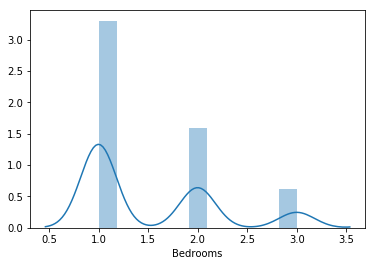

In [34]:
sns.distplot(to_rooms['Bedrooms'])

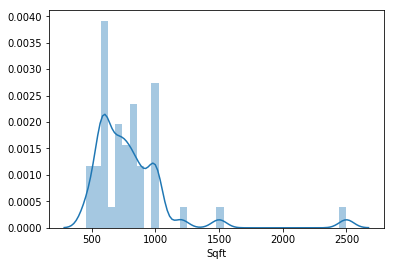

In [35]:
sns.distplot(to_rooms['Sqft'])

In [42]:
type(to_rooms)


pandas.core.frame.DataFrame

In [68]:
to_rooms['Hour']=pd.to_datetime(to_rooms['Date Posted']).dt.strftime('%Y-%m-%d-%H')
to_rooms.head()

,Date Posted,Neighborhood,Post Title,URL,Price,Sqft,Bedrooms,month,Hour
0,2019-09-04 21:19:00,Yonge # Eglinton,2 bed room new unit in a condo for rent,https://toronto.craigslist.org/tor/apa/d/toron...,2700,750.0,2.0,2019-09,2019-09-04-21
2,2019-09-04 21:18:00,Yonge # Eglinton,2 bed room new unit in a condo for rent,https://toronto.craigslist.org/tor/apa/d/toron...,2700,750.0,2.0,2019-09,2019-09-04-21
4,2019-09-04 21:15:00,250 Queens Quay Quay W,Stunning View Of The Lake And The Island Airpo...,https://toronto.craigslist.org/tor/apa/d/downt...,2550,799.0,1.0,2019-09,2019-09-04-21
7,2019-09-04 21:08:00,85 Wood St,Open & Bright Brand New Axis Condo In Prime Do...,https://toronto.craigslist.org/tor/apa/d/toron...,2550,599.0,1.0,2019-09,2019-09-04-21
8,2019-09-04 21:04:00,197 Yonge St,Stunning Beautiful 1BR+Den Condo In Luxurious ...,https://toronto.craigslist.org/tor/apa/d/toron...,2550,699.0,1.0,2019-09,2019-09-04-21


In [69]:
df=to_rooms.dropna()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 0 to 2373
Data columns (total 9 columns):
Date Posted     1125 non-null datetime64[ns]
Neighborhood    1125 non-null object
Post Title      1125 non-null object
URL             1125 non-null object
Price           1125 non-null int32
Sqft            1125 non-null float64
Bedrooms        1125 non-null float64
month           1125 non-null object
Hour            1125 non-null object
dtypes: datetime64[ns](1), float64(2), int32(1), object(5)
memory usage: 83.5+ KB


In [70]:
df.groupby(df['Hour'])['Price'].mean().reset_index()

,Hour,Price
0,2019-09-04-16,2287.500000
1,2019-09-04-17,2029.000000
2,2019-09-04-18,2333.928571
3,2019-09-04-19,2845.416667
4,2019-09-04-20,1949.857143
5,2019-09-04-21,2610.000000


In [71]:
df=df.set_index('Date Posted')
df.index

DatetimeIndex(['2019-09-04 21:19:00', '2019-09-04 21:18:00',
               '2019-09-04 21:15:00', '2019-09-04 21:08:00',
               '2019-09-04 21:04:00', '2019-09-04 20:56:00',
               '2019-09-04 20:44:00', '2019-09-04 20:24:00',
               '2019-09-04 20:23:00', '2019-09-04 20:22:00',
               ...
               '2019-09-04 18:12:00', '2019-09-04 18:08:00',
               '2019-09-04 18:05:00', '2019-09-04 17:58:00',
               '2019-09-04 17:42:00', '2019-09-04 17:03:00',
               '2019-09-04 17:02:00', '2019-09-04 17:00:00',
               '2019-09-04 16:49:00', '2019-09-04 16:49:00'],
              dtype='datetime64[ns]', name='Date Posted', length=1125, freq=None)

In [72]:
y=df['Price'].resample('H').mean()
y

Date Posted
2019-09-04 16:00:00    2287.500000
2019-09-04 17:00:00    2029.000000
2019-09-04 18:00:00    2333.928571
2019-09-04 19:00:00    2845.416667
2019-09-04 20:00:00    1949.857143
2019-09-04 21:00:00    2610.000000
Freq: H, Name: Price, dtype: float64

In [73]:
temp = pd.pivot_table(data=df, values='Price', index='Hour', aggfunc=np.mean, fill_value=0)
temp

,Price
Hour,
2019-09-04-16,2287.500000
2019-09-04-17,2029.000000
2019-09-04-18,2333.928571
2019-09-04-19,2845.416667
2019-09-04-20,1949.857143
2019-09-04-21,2610.000000


In [26]:
export_csv = to_rooms.to_csv (r'D:\PythonExercise\housedata.csv', index = None, header=True)